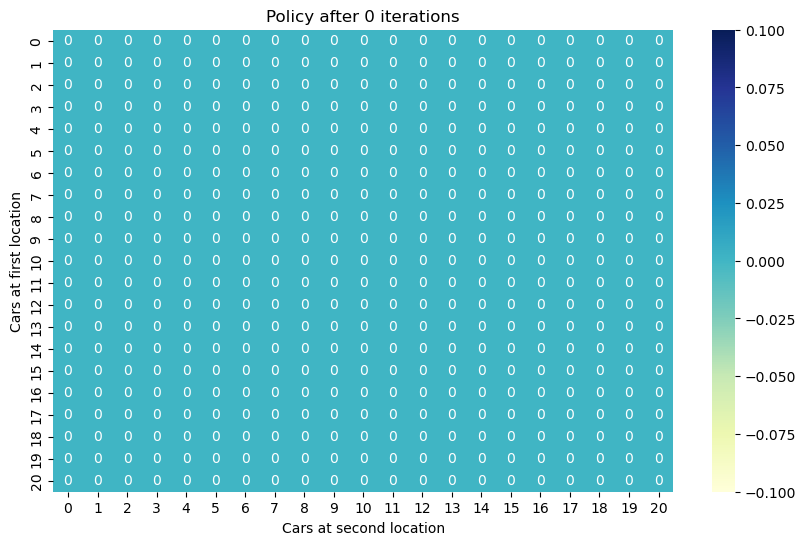

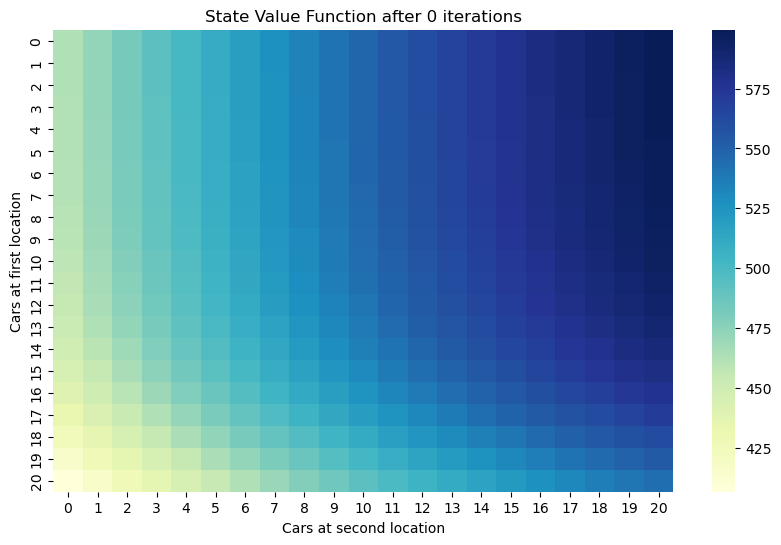

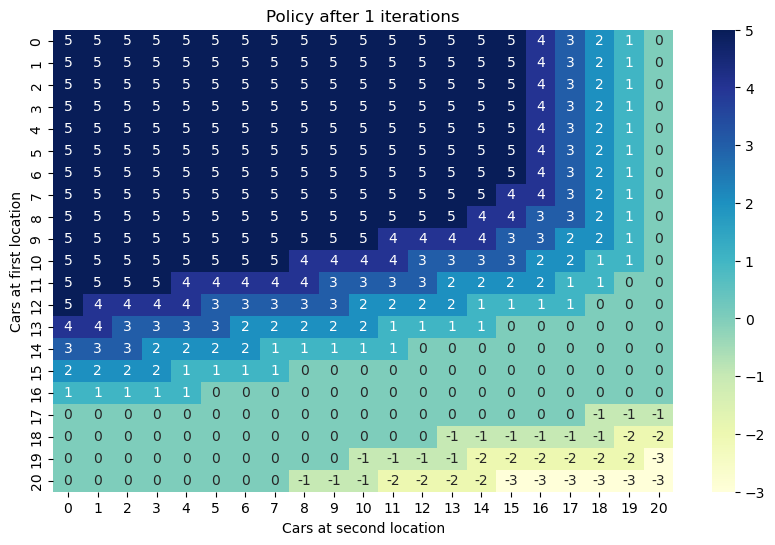

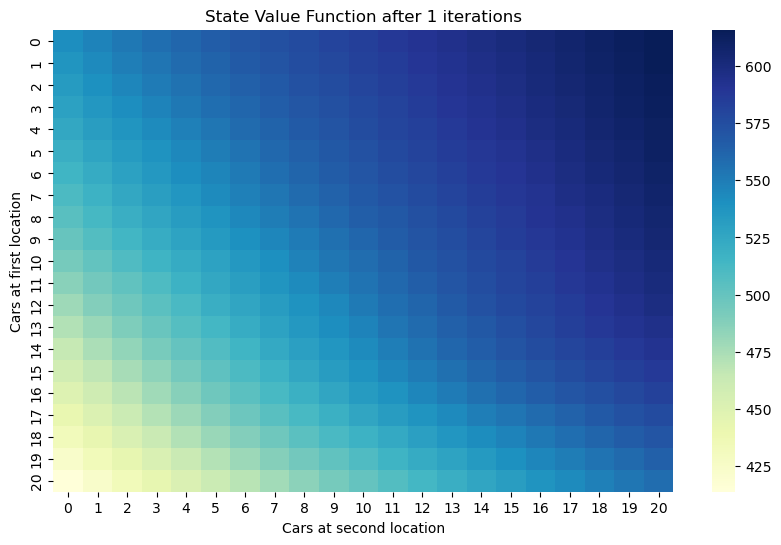

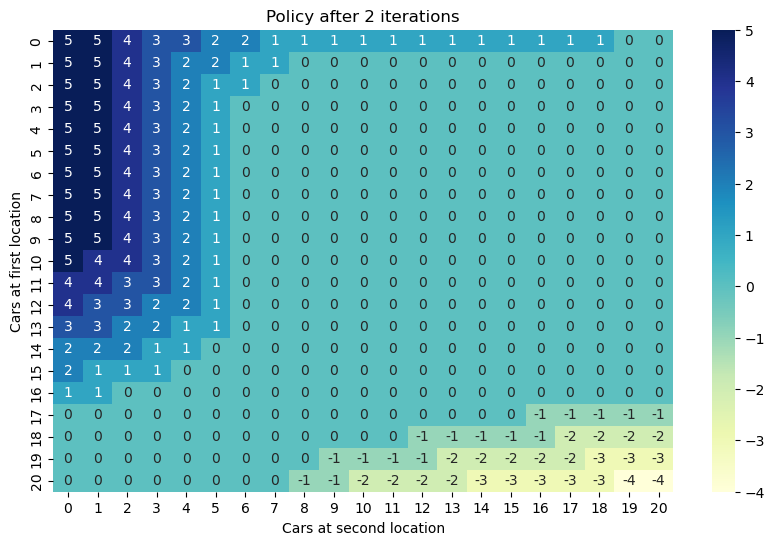

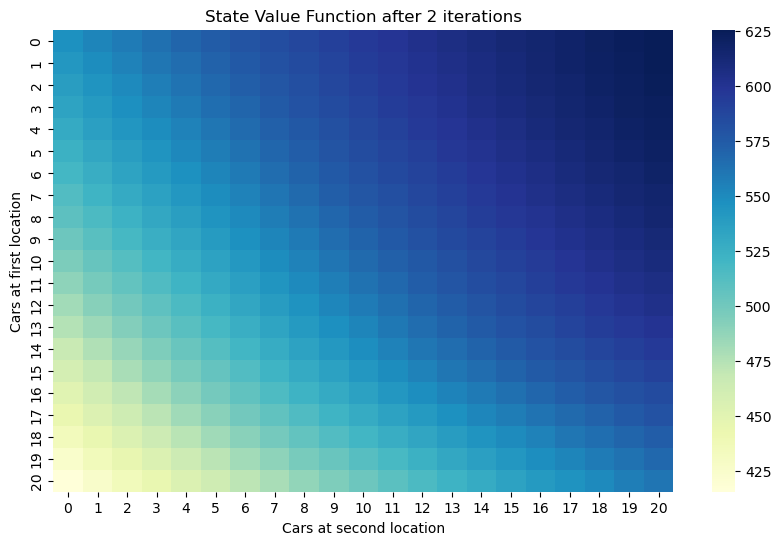

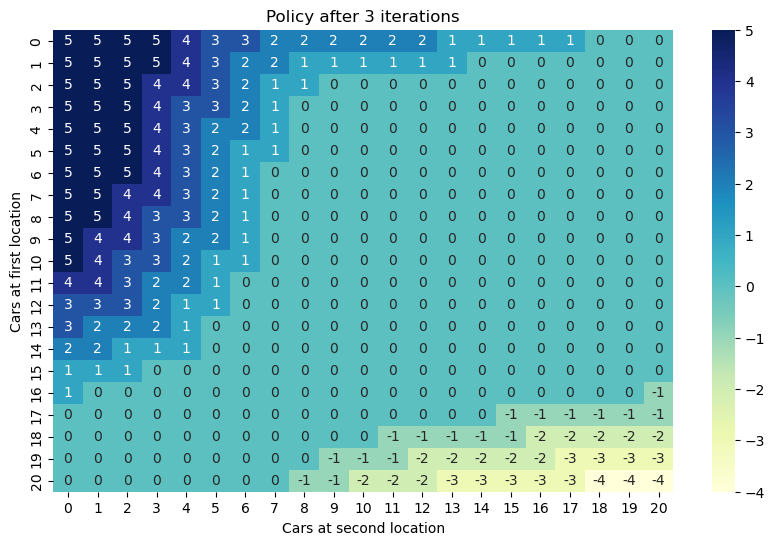

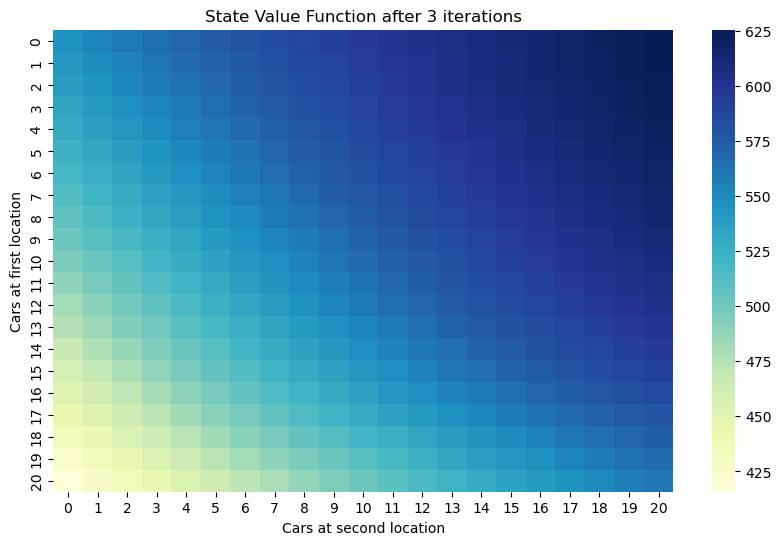

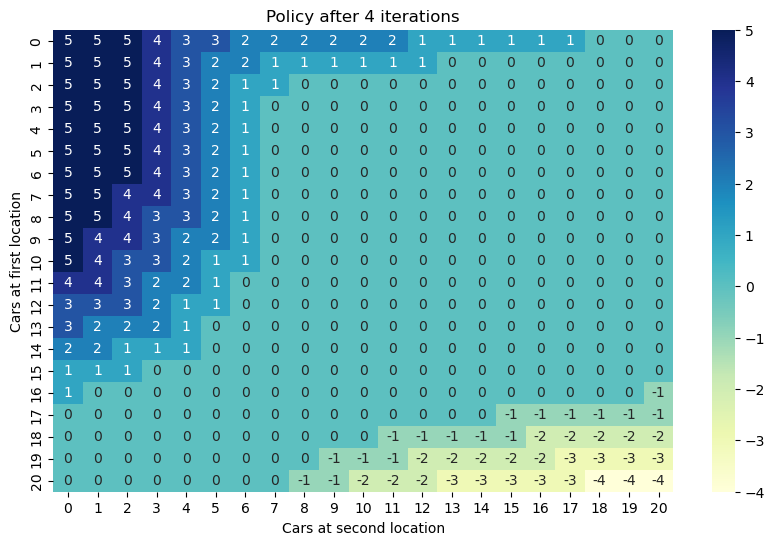

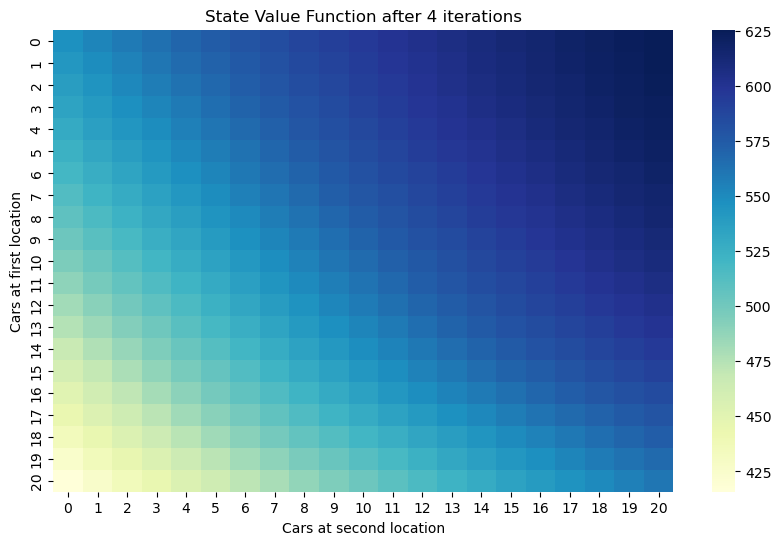

In [1]:
# Code Implemented by,
# Name: Rohith Ganesan
# Id: 20553375
# Mail: psxrg10@nottingham.ac.uk


import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns

# figures displaying problem. because of the GUI problem in macos. temp.
#plt.switch_backend('TkAgg')

# Elucidate the policy iteration algorithm

# Constants 

# maximum # of cars ni each Location 
MAX_CARS = 20 

# Maxmium #of cars to move during night
MAX_MOVE_OF_CARS = 5 

#expectation for rental requests in first Location
RENTAL_REQUEST_FIRST_LOC = 3 

#expectation for rental requests in second Location
RENTAL_REQUEST_SECOND_LOC = 4 

#expectation for # of cars returned in first Location
RETURNS_FIRST_LOC = 3

#expectation for of cars returned in second Location
RETURNS_SECOND_LOC = 2

# discount factor
DISCOUNT = 0.9

#credit earned by a car
RENTAL_CREDIT = 10

#cost of moving a car
MOVE_CAR_COST = 2


# All possible Actions
actions = np.arange(-MAX_MOVE_OF_CARS, MAX_MOVE_OF_CARS + 1)


# An up bound for poisson distribution
# If n is greater than this value, then the probability of getting n is truncated or reduced to 0
POISSON_UPPER_BOUND = 11



# Poisson cache to save computation cost
poisson_cache = dict()


#Probability for poisson distribution
#Lambda should be Less than 10 for this function
def poisson_probability(n, lam):
    global poisson_cache
    key = n * 10 + lam
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, lam)
    return poisson_cache[key]

def expected_return(state, action, state_value, constant_returned_cars):
    # Initialization
    returns = 0
    returns -= MOVE_CAR_COST * abs(action)
    # The number of cars after taking action
    cars_first_loc = min(state[0] - action, MAX_CARS)
    cars_second_loc = min(state[1] + action, MAX_CARS)

    for rental_request_first_loc in range(POISSON_UPPER_BOUND):
        for rental_request_second_loc in range(POISSON_UPPER_BOUND):
            # Probability of current rental requests
            prob = poisson_probability(rental_request_first_loc, RENTAL_REQUEST_FIRST_LOC) * \
                   poisson_probability(rental_request_second_loc, RENTAL_REQUEST_SECOND_LOC)

            # Number of cars rented at each location
            valid_rental_first_loc = min(cars_first_loc, rental_request_first_loc)
            valid_rental_second_loc = min(cars_second_loc, rental_request_second_loc)
            reward = (valid_rental_first_loc + valid_rental_second_loc) * RENTAL_CREDIT

            # Updated number of cars after rentals
            num_of_cars_first_loc = cars_first_loc - valid_rental_first_loc
            num_of_cars_second_loc = cars_second_loc - valid_rental_second_loc

            if constant_returned_cars:
                # Number of cars after considering constant returns
                num_of_cars_first_loc = min(num_of_cars_first_loc + RETURNS_FIRST_LOC, MAX_CARS)
                num_of_cars_second_loc = min(num_of_cars_second_loc + RETURNS_SECOND_LOC, MAX_CARS)
                returns += prob * (reward + DISCOUNT * state_value[num_of_cars_first_loc, num_of_cars_second_loc])
            else:
                for returned_cars_first_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_second_loc in range(POISSON_UPPER_BOUND):
                        # Probabilities of car returns
                        prob_returned = prob * poisson_probability(returned_cars_first_loc, RETURNS_FIRST_LOC) * \
                                        poisson_probability(returned_cars_second_loc, RETURNS_SECOND_LOC)
                        num_of_cars_first_loc_ = min(num_of_cars_first_loc + returned_cars_first_loc, MAX_CARS)
                        num_of_cars_second_loc_ = min(num_of_cars_second_loc + returned_cars_second_loc, MAX_CARS)
                        returns += prob_returned * (reward + DISCOUNT * state_value[num_of_cars_first_loc_, num_of_cars_second_loc_])
    return returns


# policy evaluation
def policy_evaluation(policy, state_value):
    while True:
        delta = 0
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                old_value = state_value[i, j]
                state_value[i, j] = expected_return([i, j], policy[i, j], state_value, constant_returned_cars=True)
                delta = max(delta, abs(old_value - state_value[i, j]))
        if delta < 1e-4:
            break
    return state_value


#policy improvement
def policy_improvement(policy, state_value):
    policy_stable = True
    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i, j]
            action_returns = []
            for action in actions:
                if (0 <= action <= i) or (-j <= action <= 0):
                    action_returns.append(expected_return([i, j], action, state_value, constant_returned_cars=True))
                else:
                    action_returns.append(-np.inf)
            new_action = actions[np.argmax(action_returns)]
            policy[i, j] = new_action
            if old_action != new_action:
                policy_stable = False
    return policy, policy_stable



# policy iteration
def policy_iteration():
    policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)
    state_value = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    iterations = 0

    while True:
        state_value = policy_evaluation(policy, state_value)
        # Plotting after each policy evaluation
        plot_policy(policy, iterations)
        plot_state_values(state_value, iterations)
        
        policy, policy_stable = policy_improvement(policy, state_value)
        iterations += 1
        if policy_stable:
            break

    return policy, state_value, iterations

def plot_policy(policy, iteration):
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.flipud(policy), cmap="YlGnBu", annot=True, fmt="d")
    plt.title(f"Policy after {iteration} iterations")
    plt.xlabel("Cars at second location")
    plt.ylabel("Cars at first location")
    plt.show()

def plot_state_values(state_value, iteration):
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.flipud(state_value), cmap="YlGnBu")
    plt.title(f"State Value Function after {iteration} iterations")
    plt.xlabel("Cars at second location")
    plt.ylabel("Cars at first location")
    plt.show()

# Run the policy iteration
policy, state_value, iterations = policy_iteration()


